# Calculate the average 2D image of a run

## Example that uses the Bernina Environment

In [4]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time, sys

In [5]:
sys.path.insert(0, '../src/')
from integrators import *

In [2]:
run = '0000_test01'
data = swissfel.parseScanEco_v01('/sf/bernina/data/p17743/res/scan_info/run%s.json'%run,
                                 createEscArrays=True, 
                                 memlimit_mD_MB=50)

Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch3-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch4-TIME-AXIS in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-TIME-AXIS in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch4-DATA-AMP in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch3-TIME-AXIS in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch2-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-DATA-AMP in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch2-TIME-AXIS in cycle 0
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch1-DATA-AMP in cycle 1
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch3-DATA-AMP in cycle 1
Found empty dataset in SAROP21-CVME-PBPS2:Lnk9Ch

In [3]:
jf7 = data['JF07T32V01']

with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

In [8]:
num_shots = jf7.data.shape[jf7.eventDim]
print(num_shots)
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)
icorr_sum = apply_geometry(icorr,'JF07T32V01')
rad_dist = radial_distances(icorr_sum)
r, iq = angular_average(icorr_sum, rad=rad_dist) # memory error with mask, why?
iqs = np.zeros((num_shots, iq.shape[0]))
iqs[0] = iq

for i_shot in range(1,10):#num_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7.data[i_shot].compute(),G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    r, iq = angular_average(icorr_geom, rad=rad_dist) # memory error with mask, why?
    iqs[i_shot] = iq
    icorr_sum += icorr_geom 
    
    print('%.1f Hz'%(1.0/(time.time() - t1)))
    
#mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
#icorr_geom_mask = icorr_geom
#icorr_geom_mask[mask_geom] = np.nan


1100
0.5 Hz
0.4 Hz
0.5 Hz
0.4 Hz
0.4 Hz
0.4 Hz
0.5 Hz
0.4 Hz
0.4 Hz


<IPython.core.display.Javascript object>


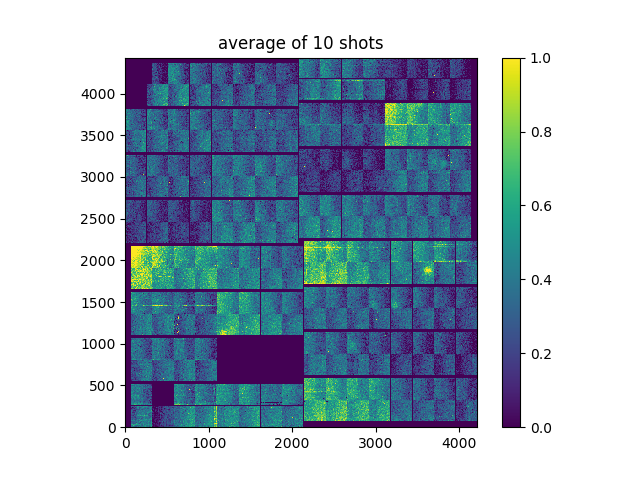

In [22]:
plt.figure()
plt.title('average of %d shots' % (i_shot+1))
plt.imshow(icorr_sum/(i_shot+1),clim=[0,1],origin='lower')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


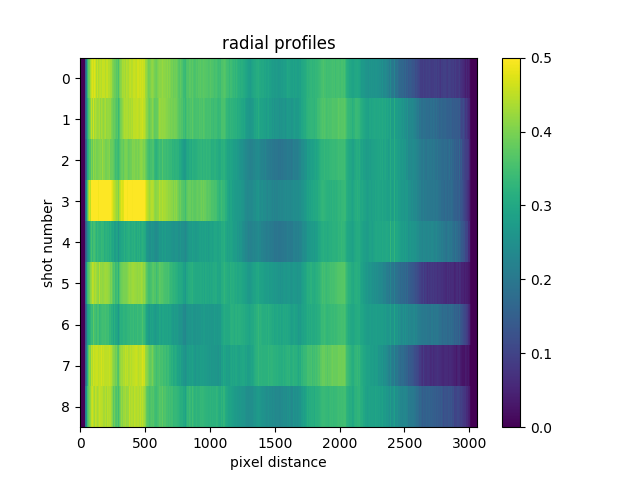

In [23]:
plt.figure()
plt.title('radial profiles')
plt.ylabel('shot number')
plt.xlabel('pixel distance')
plt.imshow(iqs[0:i_shot],aspect='auto',clim=[0,0.5])
plt.colorbar()
plt.show()

float32
